# Goal: Predict whether a client will subscribe to a bank term deposit.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from xgboost import XGBClassifier

from sklearn.neural_network import MLPClassifier

import optuna, joblib, ast

/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Train set

In [3]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


In [4]:
train_df.shape

(750000, 18)

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         750000 non-null  int64 
 1   age        750000 non-null  int64 
 2   job        750000 non-null  object
 3   marital    750000 non-null  object
 4   education  750000 non-null  object
 5   default    750000 non-null  object
 6   balance    750000 non-null  int64 
 7   housing    750000 non-null  object
 8   loan       750000 non-null  object
 9   contact    750000 non-null  object
 10  day        750000 non-null  int64 
 11  month      750000 non-null  object
 12  duration   750000 non-null  int64 
 13  campaign   750000 non-null  int64 
 14  pdays      750000 non-null  int64 
 15  previous   750000 non-null  int64 
 16  poutcome   750000 non-null  object
 17  y          750000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 103.0+ MB


In [6]:
for col in ["job","marital","education","default","housing","loan","contact","month","poutcome","y"]:
    train_df[col] = train_df[col].astype("category")

num_type_map = {
    "id": "int32",
    "age": "int16",
    "balance": "int32",
    "day": "int8",
    "duration": "int32",
    "campaign": "int16",
    "pdays": "int32",
    "previous": "int16",
}
train_df = train_df.astype(num_type_map)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 18 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   id         750000 non-null  int32   
 1   age        750000 non-null  int16   
 2   job        750000 non-null  category
 3   marital    750000 non-null  category
 4   education  750000 non-null  category
 5   default    750000 non-null  category
 6   balance    750000 non-null  int32   
 7   housing    750000 non-null  category
 8   loan       750000 non-null  category
 9   contact    750000 non-null  category
 10  day        750000 non-null  int8    
 11  month      750000 non-null  category
 12  duration   750000 non-null  int32   
 13  campaign   750000 non-null  int16   
 14  pdays      750000 non-null  int32   
 15  previous   750000 non-null  int16   
 16  poutcome   750000 non-null  category
 17  y          750000 non-null  category
dtypes: category(10), int16(3), int32(4), int8(1)

In [7]:
num_cols = train_df.select_dtypes(include=["int8", "int16", "int32"]).columns.tolist()
cat_cols = train_df.select_dtypes(include=["category"]).columns.tolist()

num_cols.remove("id")
cat_cols.remove("y")
print("Train set:")
print(f"There are {len(num_cols)} numerical columns.")
print(f"There are {len(cat_cols)} categorical columns.")

Train set:
There are 7 numerical columns.
There are 9 categorical columns.


In [8]:
train_df[num_cols].describe()

,age,balance,day,duration,campaign,pdays,previous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000


In [9]:
train_df[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,750000,750000,750000,750000,750000,750000,750000,750000,750000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,175541,480759,401683,737151,411288,645023,486655,228411,672450


# Test set

In [10]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,750000,32,blue-collar,married,secondary,no,1397,yes,no,unknown,21,may,224,1,-1,0,unknown
1,750001,44,management,married,tertiary,no,23,yes,no,cellular,3,apr,586,2,-1,0,unknown
2,750002,36,self-employed,married,primary,no,46,yes,yes,cellular,13,may,111,2,-1,0,unknown
3,750003,58,blue-collar,married,secondary,no,-1380,yes,yes,unknown,29,may,125,1,-1,0,unknown
4,750004,28,technician,single,secondary,no,1950,yes,no,cellular,22,jul,181,1,-1,0,unknown


In [11]:
test_df.shape

(250000, 17)

In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         250000 non-null  int64 
 1   age        250000 non-null  int64 
 2   job        250000 non-null  object
 3   marital    250000 non-null  object
 4   education  250000 non-null  object
 5   default    250000 non-null  object
 6   balance    250000 non-null  int64 
 7   housing    250000 non-null  object
 8   loan       250000 non-null  object
 9   contact    250000 non-null  object
 10  day        250000 non-null  int64 
 11  month      250000 non-null  object
 12  duration   250000 non-null  int64 
 13  campaign   250000 non-null  int64 
 14  pdays      250000 non-null  int64 
 15  previous   250000 non-null  int64 
 16  poutcome   250000 non-null  object
dtypes: int64(8), object(9)
memory usage: 32.4+ MB


In [13]:
for col in ["job","marital","education","default","housing","loan","contact","month","poutcome"]:
    test_df[col] = test_df[col].astype("category")

num_type_map = {
    "id": "int32",
    "age": "int16",
    "balance": "int32",
    "day": "int8",
    "duration": "int32",
    "campaign": "int16",
    "pdays": "int32",
    "previous": "int16",
}
test_df = test_df.astype(num_type_map)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 17 columns):
 #   Column     Non-Null Count   Dtype   
---  ------     --------------   -----   
 0   id         250000 non-null  int32   
 1   age        250000 non-null  int16   
 2   job        250000 non-null  category
 3   marital    250000 non-null  category
 4   education  250000 non-null  category
 5   default    250000 non-null  category
 6   balance    250000 non-null  int32   
 7   housing    250000 non-null  category
 8   loan       250000 non-null  category
 9   contact    250000 non-null  category
 10  day        250000 non-null  int8    
 11  month      250000 non-null  category
 12  duration   250000 non-null  int32   
 13  campaign   250000 non-null  int16   
 14  pdays      250000 non-null  int32   
 15  previous   250000 non-null  int16   
 16  poutcome   250000 non-null  category
dtypes: category(9), int16(3), int32(4), int8(1)
memory usage: 7.6 MB


In [14]:
num_cols = test_df.select_dtypes(include=["int8", "int16", "int32"]).columns.tolist()
cat_cols = test_df.select_dtypes(include=["category"]).columns.tolist()

num_cols.remove("id")
print("Test set:")
print(f"There are {len(num_cols)} numerical columns.")
print(f"There are {len(cat_cols)} categorical columns.")

Test set:
There are 7 numerical columns.
There are 9 categorical columns.


In [15]:
test_df[num_cols].describe()

,age,balance,day,duration,campaign,pdays,previous
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,40.932332,1197.426352,16.116068,255.342260,2.573548,22.280028,0.303728
std,10.081613,2741.520699,8.258509,271.404326,2.709661,76.915879,1.384574
min,18.000000,-8019.000000,1.000000,3.000000,1.000000,-1.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000
50%,39.000000,631.000000,17.000000,133.000000,2.000000,-1.000000,0.000000
75%,48.000000,1389.000000,21.000000,353.000000,3.000000,-1.000000,0.000000
max,95.000000,98517.000000,31.000000,4918.000000,58.000000,871.000000,150.000000


In [16]:
test_df[cat_cols].describe()

,job,marital,education,default,housing,loan,contact,month,poutcome
count,250000,250000,250000,250000,250000,250000,250000,250000,250000
unique,12,3,4,2,2,2,3,12,4
top,management,married,secondary,no,yes,no,cellular,may,unknown
freq,58636,160412,133724,245843,136534,214957,162462,76009,224115


# Imbalance Data
The dataset is imbalanced, with about 88% of the samples labeled as 0 (won"t subscribe) and only 12% labeled as 1 (will subscribe).

In [17]:
train_df.y.value_counts(normalize=True)*100

y
0    87.934933
1    12.065067
Name: proportion, dtype: float64

# EDA

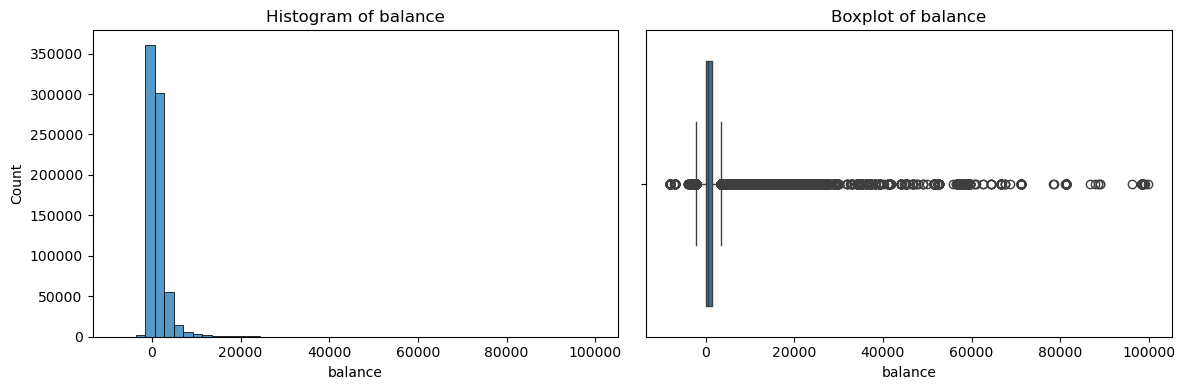

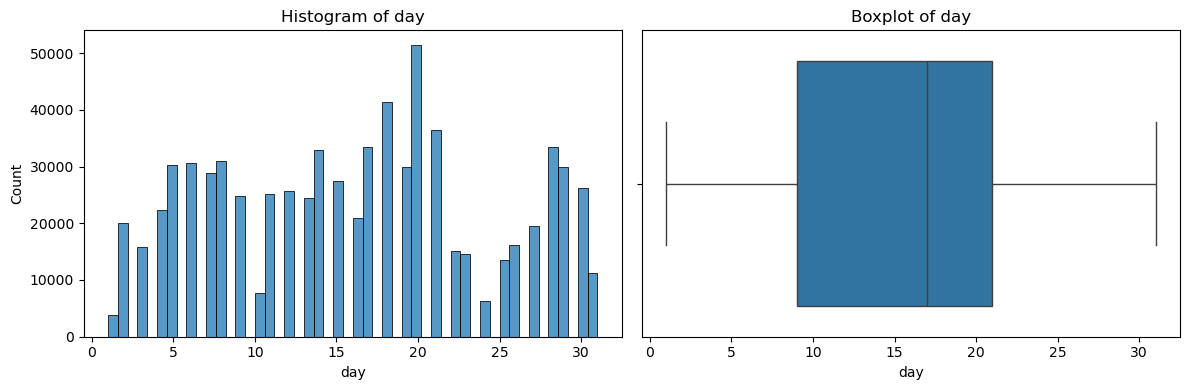

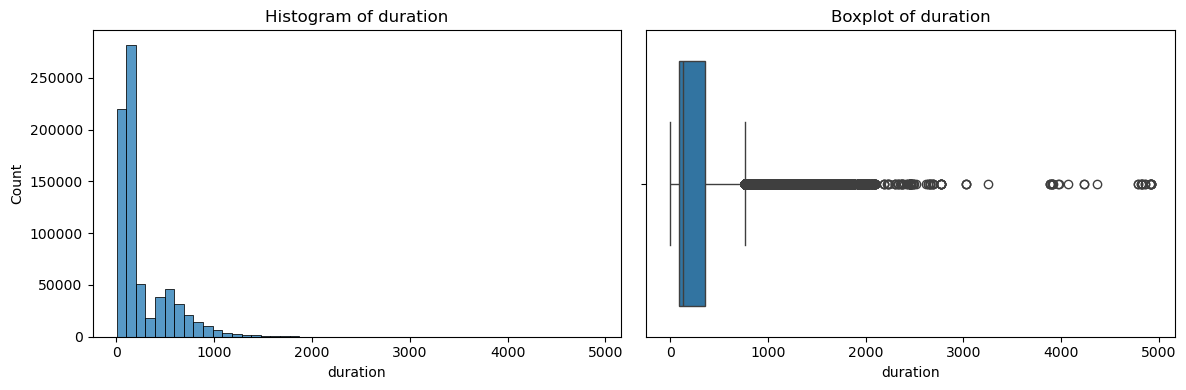

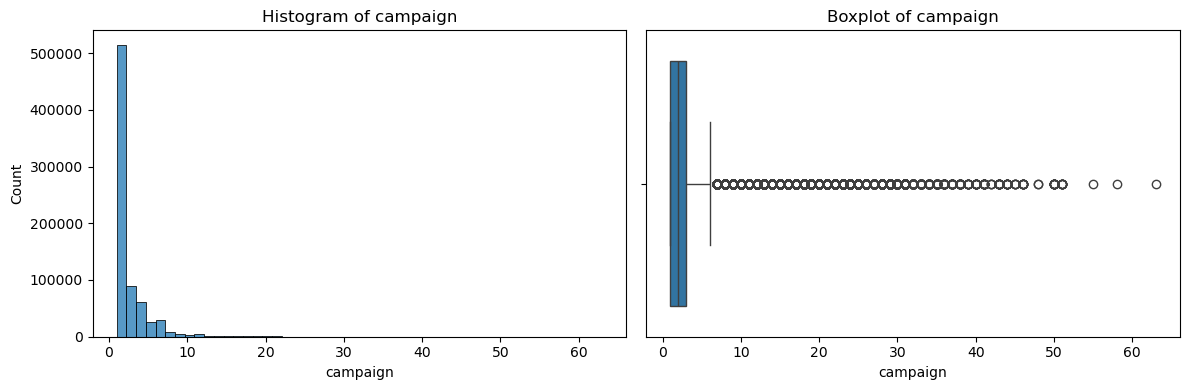

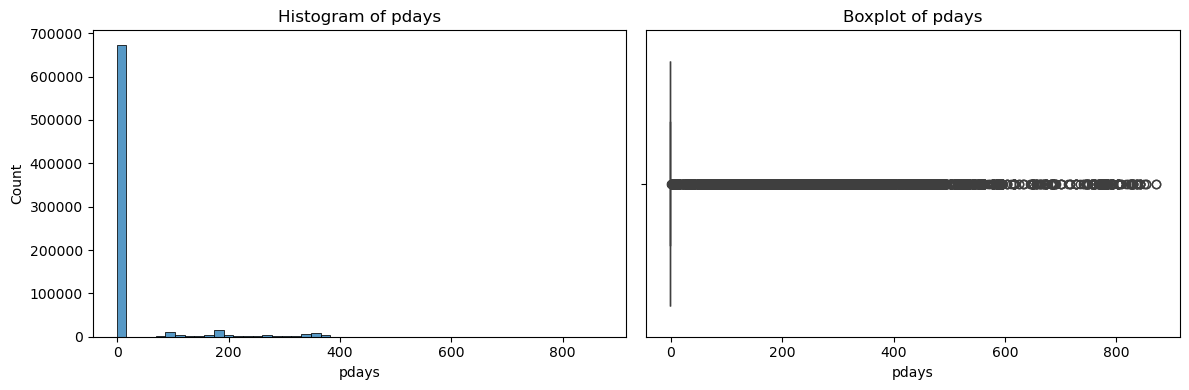

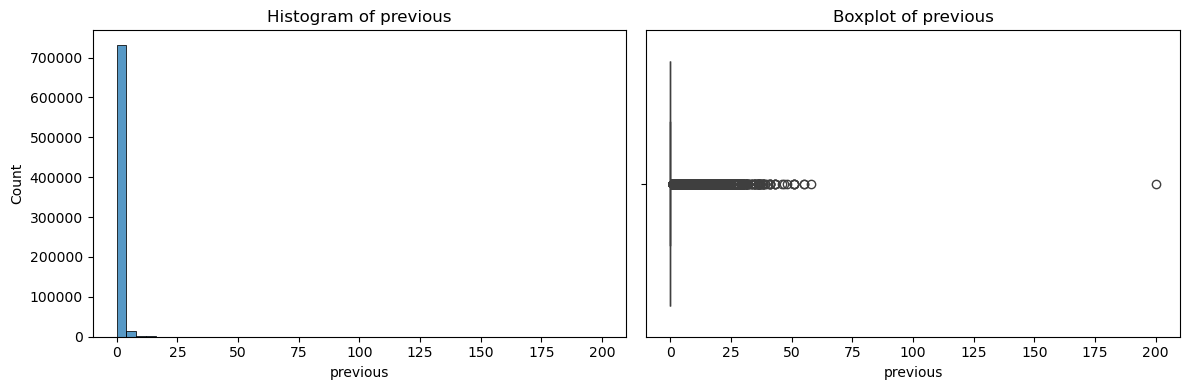

In [18]:
for col in num_cols[1:]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # histogram
    sns.histplot(train_df[col], bins=50, kde=False, ax=axes[0])
    axes[0].set_title(f"Histogram of {col}")

    # boxplot
    sns.boxplot(x=train_df[col], ax=axes[1])
    axes[1].set_title(f"Boxplot of {col}")

    plt.tight_layout()
    plt.show()

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


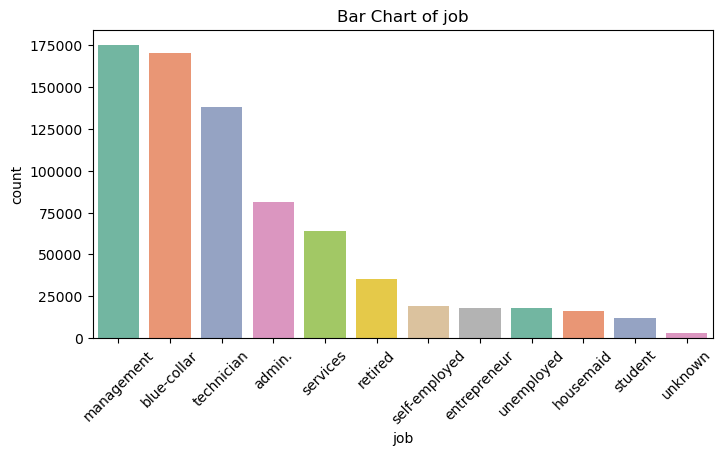

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


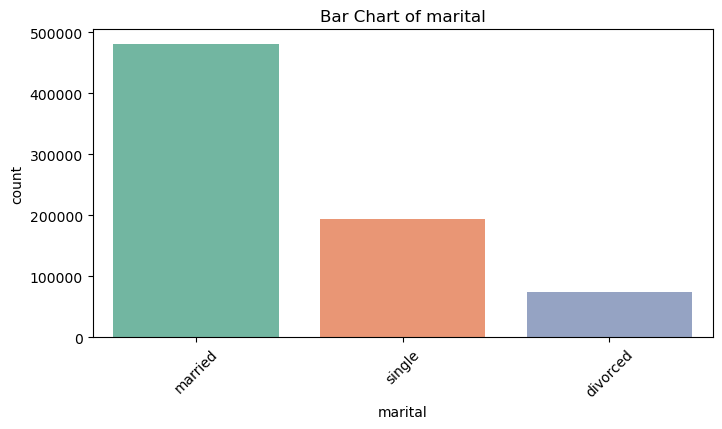

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


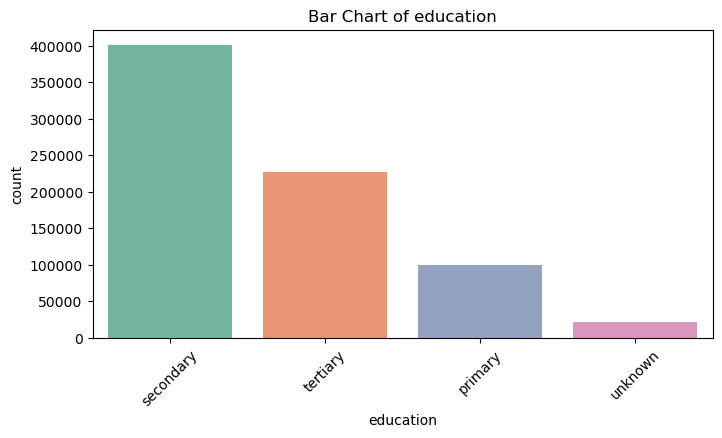

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


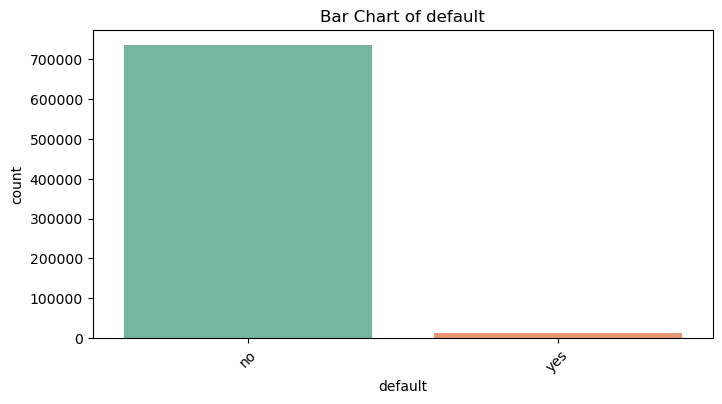

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


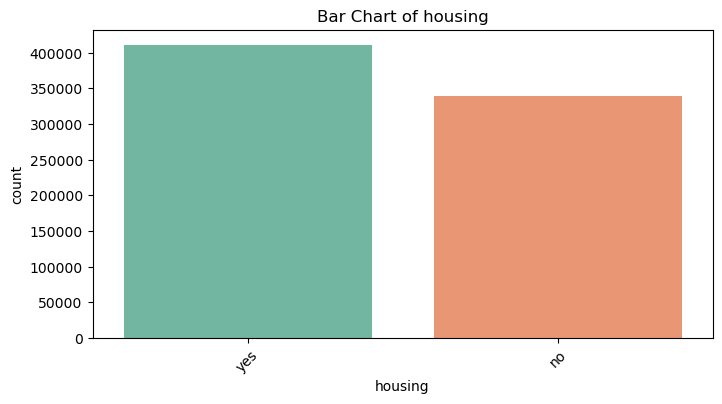

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


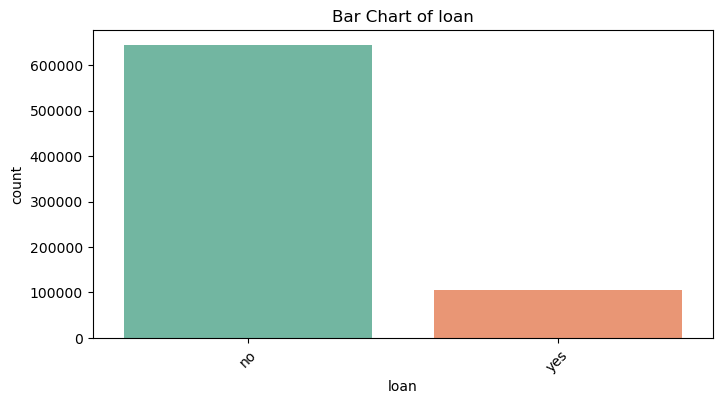

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


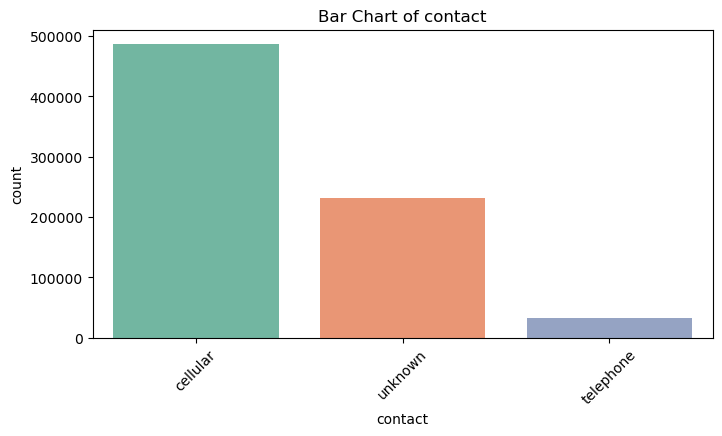

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


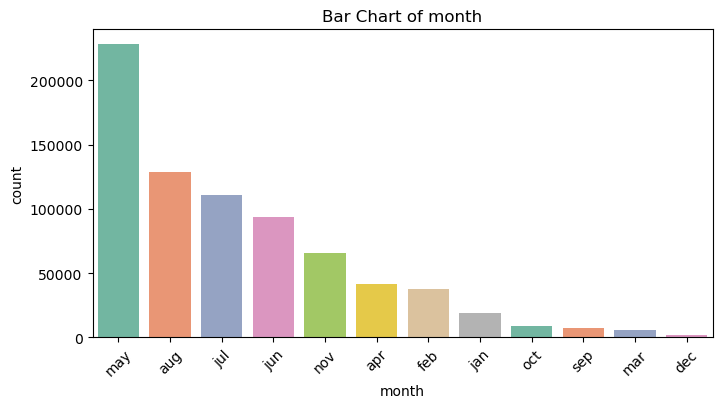

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")


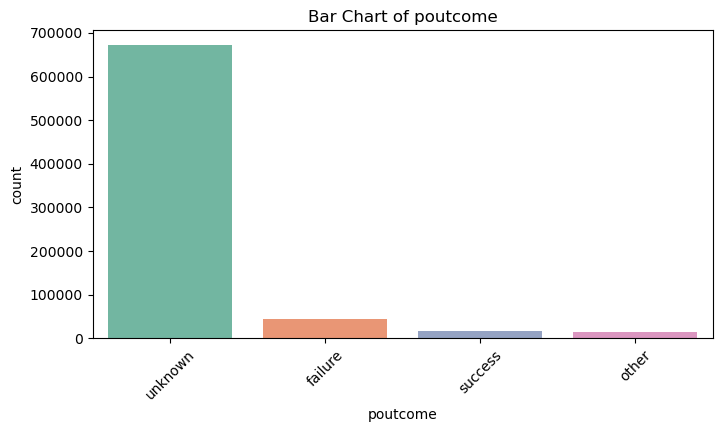

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


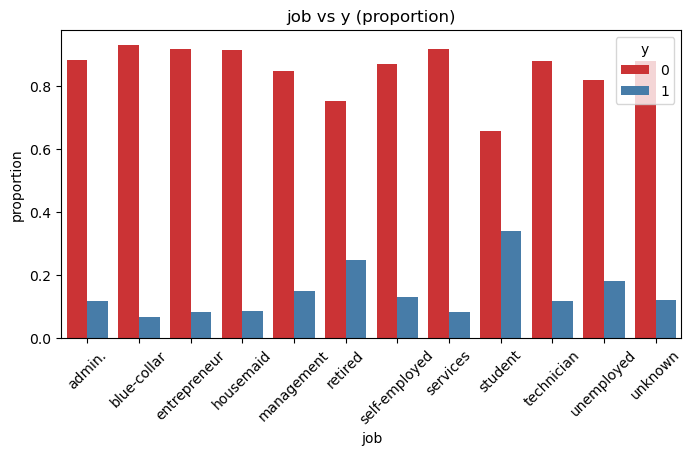

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


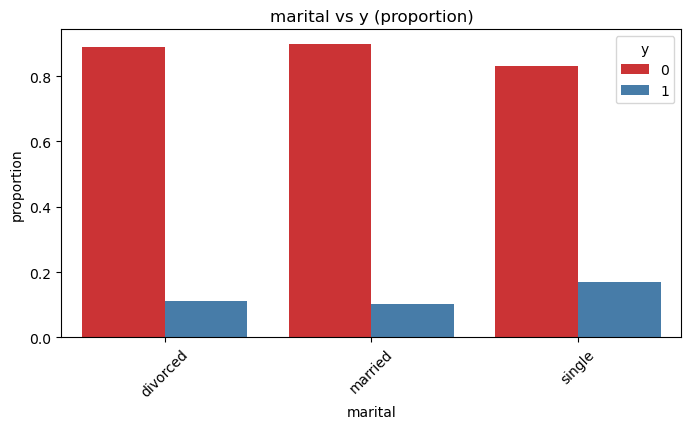

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


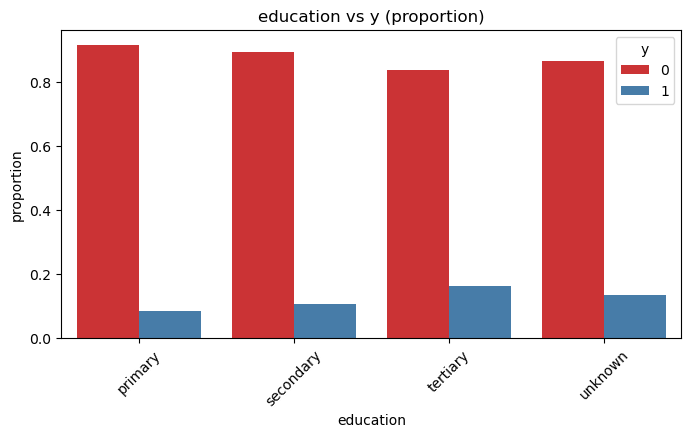

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


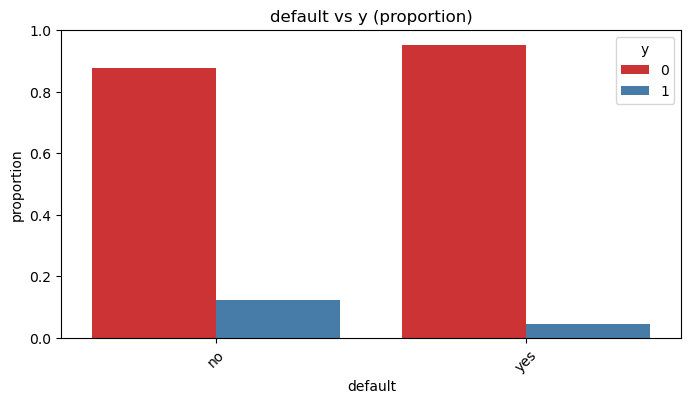

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


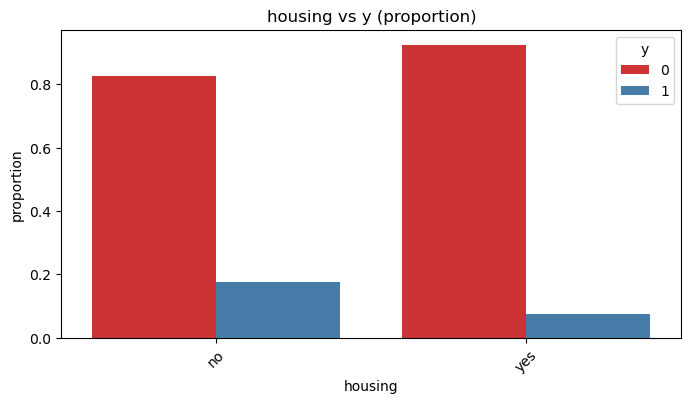

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


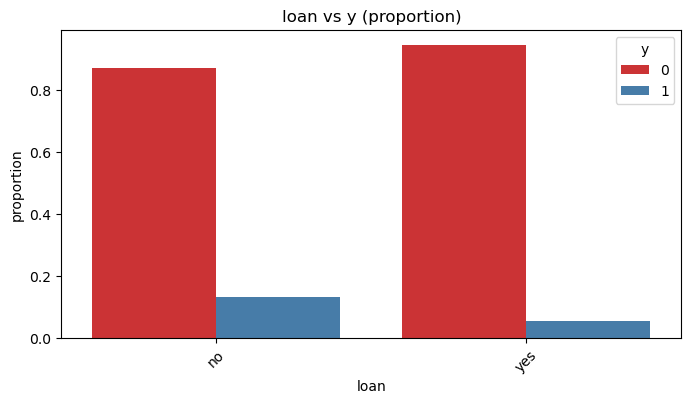

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


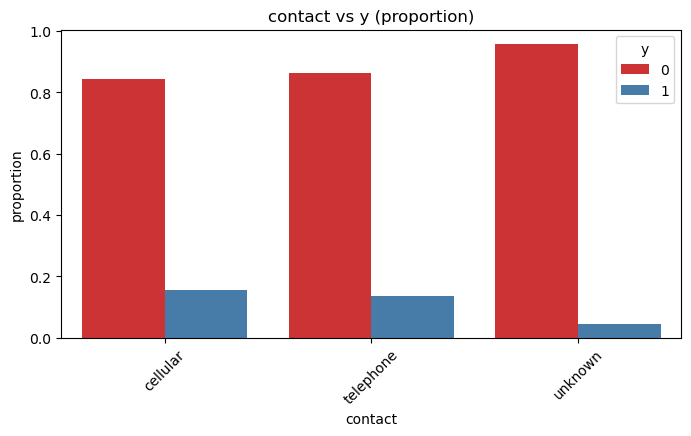

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


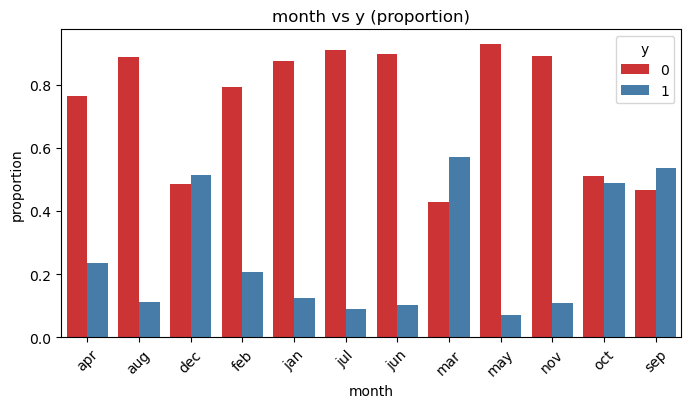

/var/folders/kz/4r69ck_n1wn471jb0n5gyhc80000gn/T/ipykernel_50667/4024228259.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)


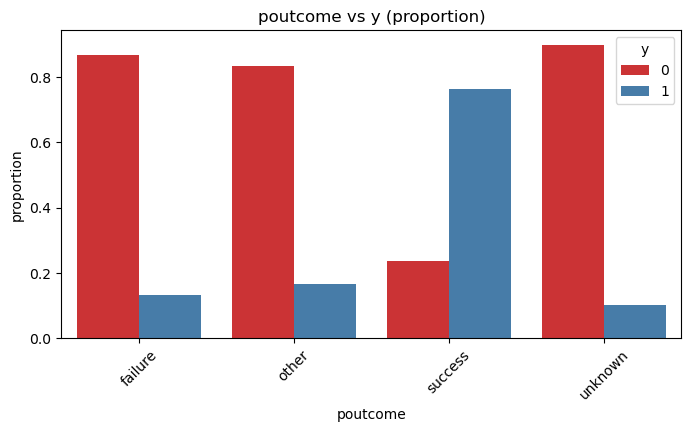

In [19]:
# barplot
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, data=train_df, order=train_df[col].value_counts().index, palette="Set2")
    plt.title(f"Bar Chart of {col}")
    plt.xticks(rotation=45)
    plt.show()

# categorical column vs y ratios
for col in cat_cols:
    if col != "y":
        plt.figure(figsize=(8,4))
        prop_df = (train_df.groupby(col)["y"].value_counts(normalize=True)
                                  .rename("proportion").reset_index())
        sns.barplot(x=col, y="proportion", hue="y", data=prop_df, palette="Set1")
        plt.title(f"{col} vs y (proportion)")
        plt.xticks(rotation=45)
        plt.show()

# Feature Selection
- Compare Decision Tree Classifier and Random Forest Classifier
- Both select Top 10 features

In [20]:
def select_features_with_tree(model, X, y, top_n):
    categorical_cols = X.select_dtypes(include="category").columns.tolist()
    numeric_cols = X.select_dtypes(exclude="category").columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ])

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])

    pipeline.fit(X, y)
    
    feature_names = [f.split("__")[-1] for f in pipeline.named_steps["preprocessor"].get_feature_names_out()]
    importances = pipeline.named_steps["model"].feature_importances_
    
    importances_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)
    print(importances_df.head(top_n))

    selected_features = importances_df.head(top_n)["feature"].tolist()

    importances_df.head(top_n).plot.barh(x="feature", y="importance", figsize=(8,6), title=f"Top {top_n} Features")
    
    return selected_features, importances_df

In [21]:
ALL_FEATURES = [
    "age","job","marital","education","default","balance","housing","loan",
    "contact","day","month", "duration", "campaign","pdays","previous","poutcome"
]
len(ALL_FEATURES)

16

In [22]:
X = train_df[ALL_FEATURES]
y = train_df["y"]

     feature  importance
12  duration    0.406235
10   balance    0.118968
9        age    0.076697
11       day    0.073090
7      month    0.064736
14     pdays    0.054630
4    housing    0.052297
0        job    0.034818
13  campaign    0.027068
6    contact    0.022348


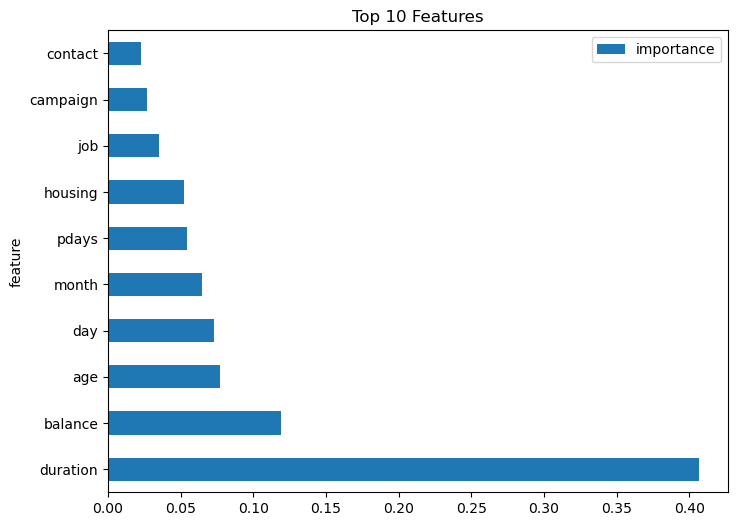

In [23]:
# 使用 Decision Tree
dt_features, dt_importance_df = select_features_with_tree(
    model=DecisionTreeClassifier(random_state=42),
    X=X,
    y=y,
    top_n=10
)

     feature  importance
12  duration    0.403337
10   balance    0.123925
9        age    0.088050
11       day    0.072557
7      month    0.066820
0        job    0.036875
8   poutcome    0.033954
13  campaign    0.031630
14     pdays    0.030744
4    housing    0.029731


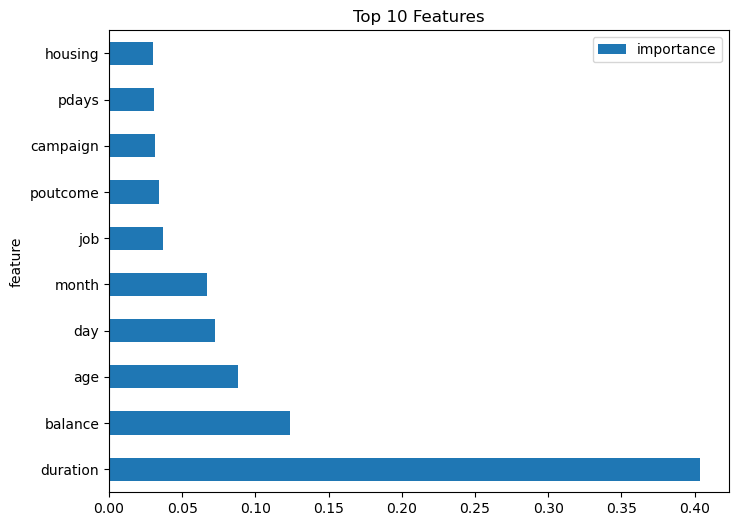

In [24]:
# 使用 Random Forest
rf_features, rf_importance_df = select_features_with_tree(
    model=RandomForestClassifier(random_state=42),
    X=X,
    y=y,
    top_n=10
)

In [25]:
print(f"Top 10 features from Decision Tree: {dt_features}")
print(f"Top 10 features from Random Forest: {rf_features}")

Top 10 features from Decision Tree: ['duration', 'balance', 'age', 'day', 'month', 'pdays', 'housing', 'job', 'campaign', 'contact']
Top 10 features from Random Forest: ['duration', 'balance', 'age', 'day', 'month', 'job', 'poutcome', 'campaign', 'pdays', 'housing']


In [26]:
diff_col = len(set(dt_features) ^ set(rf_features))
print(f"There are {diff_col} different features between Decision Tree and Random Forest top 10 features.")
print(set(dt_features) ^ set(rf_features))

There are 2 different features between Decision Tree and Random Forest top 10 features.
{'contact', 'poutcome'}


In [27]:
final_features = list(set(dt_features) | set(rf_features))
print(f"Final selected features (union): {final_features}")

Final selected features (union): ['month', 'pdays', 'contact', 'age', 'campaign', 'duration', 'poutcome', 'day', 'housing', 'balance', 'job']


In [28]:
X_final = X[final_features]
X_final_dummy = pd.get_dummies(X_final)

# Handling imbalanced data

* For classification problem
* Resampling method:
    * Undersampling -> 減少樣本
    * Oversampling -> 增加樣本
* Undersampling:
    * 減少資料量，使訓練更快、記憶體／運算負擔變小。
    * 若刪除的是重複或不具代表性的樣本，可能清除 noise，有助於模型學習乾淨的邊界。
    * 有可能刪除掉對分類很重要的樣本—喪失資訊 (information loss)。
    * 對於原本樣本就不多的情況，下採樣會使資料更稀疏，模型可能變得不穩定（variance 增加）。
    * 在極端不平衡、少數樣本非常少時，過度下採樣可能造成分類能力大幅下降。

* Oversampling:
    * SMOTE method: 對少數類別的每個樣本，選擇其 k 個最近鄰（在少數類別內部），然後在該樣本與某個鄰居之間做插值 (interpolation) 生成新的樣本點。
    * SMOTE 比 Undersampling 表現更好。
    * Oversampling 通常不會像在傳統模型中那麼容易導致 Overfitting
    * 合成樣本可能導致分佈偏離真實資料分佈（特別是在特徵空間複雜或類別邊界模糊時）。
    * 若合成方式沒選好，可能產生類別間重疊（class overlap）或在邊界附近生成錯誤樣本。

In [29]:
def undersample_pipeline(X, y, random_state=42):
    print("Using Undersampling")
    print("Before sampling:", y.value_counts().to_dict())
    
    categorical_cols = X.select_dtypes(include="category").columns.tolist()
    numeric_cols = X.select_dtypes(exclude="category").columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ])

    X_transformed = preprocessor.fit_transform(X)
    
    rus = RandomUnderSampler(random_state=random_state)
    X_resampled, y_resampled = rus.fit_resample(X_transformed, y)
    print("After sampling:", y_resampled.value_counts().to_dict())
    
    return X_resampled, y_resampled

In [30]:
def smote_pipeline(X, y, random_state=42):
    print("Using SMOTE")
    print("Before sampling:", y.value_counts().to_dict())

    categorical_cols = X.select_dtypes(include="category").columns.tolist()
    numeric_cols = X.select_dtypes(exclude="category").columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ("cat", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ])

    X_transformed = preprocessor.fit_transform(X)
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X_transformed, y)
    print("After sampling:", y_resampled.value_counts().to_dict())
    
    return X_resampled, y_resampled

# Modeling

- 1 * 3 * 3 = 9 組實驗組合
  - 合併 2 種特徵選擇方法 (DecisionTree / RandomForest) -> 選擇 11 個特徵
  - 3 種資料平衡方法 (SMOTE / Undersampling / 無處理)
  - 3 種模型進行訓練 (Random Forest / XGBoost / MLP)
- 使用 Optuna 完成超參數調整
  - n_trails: 嘗試 n 組超參數組合，從中選出最佳的一組超參數
- 5-fold 交叉驗證
- Evaluations:
  - Accuracy
  - Precision
  - Recall
  - F1 score


In [31]:
def evaluate_model_cv(model, X, y, model_name, n_splits):
    scoring = ["accuracy", "precision", "recall", "f1"]

    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    result = {
        "model": model_name,
        "accuracy": scores["test_accuracy"].mean(),
        "precision": scores["test_precision"].mean(),
        "recall": scores["test_recall"].mean(),
        "f1_score": scores["test_f1"].mean()
    }

    return result

## Optimize Random Forest

In [32]:
def optimize_rf(X, y, n_trials):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 15),
            "min_samples_split": trial.suggest_int("min_samples_split", 5, 10),
        }
        model = RandomForestClassifier(**params, random_state=42)
        result = evaluate_model_cv(model, X, y, "Random Forest", n_splits=5)
        return result["f1_score"]
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params


## Optimize XGBoost

In [33]:
def optimize_xgb(X, y, n_trials):
    def objective(trial):
        params = {
            "n_estimators": trial.suggest_int("n_estimators", 200, 300),
            "max_depth": trial.suggest_int("max_depth", 5, 15),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
            "subsample": trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0)
        }
        model = XGBClassifier(**params, random_state=42)
        result = evaluate_model_cv(model, X, y, "XGBoost", n_splits=5)
        return result["f1_score"]
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params

## Optimize MLP

In [34]:
def optimize_mlp(X, y, n_trials):
    def objective(trial):
        params = {
            "hidden_layer_sizes": trial.suggest_categorical(
                "hidden_layer_sizes", [(128, 64), (256, 128)]
            ),
            "learning_rate_init": trial.suggest_float("learning_rate_init", 0.0001, 0.01, log=True),
            "alpha": trial.suggest_float("alpha", 0.0001, 0.01, log=True),
            "activation": trial.suggest_categorical("activation", ["relu", "tanh"]),
            "batch_size": trial.suggest_categorical("batch_size", [256, 512, 1024])
        }
        model = MLPClassifier(**params, max_iter=300, early_stopping=True, random_state=42)
        result = evaluate_model_cv(model, X, y, "MLP", n_splits=5)
        return result["f1_score"]
    
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)
    
    return study.best_params

In [35]:
results = []
n_trials=5
n_splits = 5
ex_cnt = 1

# sampling method combination
sampling_methods = [
    ("Undersampling", undersample_pipeline),
    ("SMOTE", smote_pipeline),
    ("None", lambda X, y: (X, y))
]

# model and optimizer function
model_optimizers = {
    "Random Forest": (RandomForestClassifier, optimize_rf),
    "XGBoost": (XGBClassifier, optimize_xgb),
    "MLP": (MLPClassifier, optimize_mlp)
}

for samp_name, samp_func in sampling_methods:
    X_res, y_res = samp_func(X_final_dummy, y)

    for model_name, (model_cls, optimizer_func) in model_optimizers.items():
        print(f"===Experiment {ex_cnt}, Resampling Method: {samp_name}, Model: {model_name}===")
        best_params = optimizer_func(X_res, y_res, n_trials=n_trials)

        print("Using best params to build model")
        model = model_cls(**best_params, random_state=42)

        print(f"Evaluating (n_splits={n_splits})...")
        metrics = evaluate_model_cv(model, X_res, y_res, model_name, n_splits)
        print(f'Average Accuracy: {metrics["accuracy"]}')
        
        results.append({
            "Resampling": samp_name,
            "Model": model_name,
            **metrics,
            **best_params
        })
        print("\n")
        ex_cnt += 1

results_df = pd.DataFrame(results)
results_df.to_csv("./output/experiment_results.csv", index=False)

Using Undersampling
Before sampling: {0: 659512, 1: 90488}


[I 2025-11-06 19:13:20,137] A new study created in memory with name: no-name-9fc96f52-e484-47db-a6d5-33efc990e2cb


After sampling: {0: 90488, 1: 90488}
===Experiment 1, Resampling Method: Undersampling, Model: Random Forest===


[I 2025-11-06 19:13:31,818] Trial 0 finished with value: 0.8887826483773843 and parameters: {'n_estimators': 187, 'max_depth': 6, 'min_samples_split': 5}. Best is trial 0 with value: 0.8887826483773843.
[I 2025-11-06 19:13:48,117] Trial 1 finished with value: 0.8985703648405842 and parameters: {'n_estimators': 188, 'max_depth': 11, 'min_samples_split': 10}. Best is trial 1 with value: 0.8985703648405842.
[I 2025-11-06 19:14:00,441] Trial 2 finished with value: 0.8845136892872446 and parameters: {'n_estimators': 229, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 1 with value: 0.8985703648405842.
[I 2025-11-06 19:14:19,320] Trial 3 finished with value: 0.8950459031109184 and parameters: {'n_estimators': 237, 'max_depth': 9, 'min_samples_split': 5}. Best is trial 1 with value: 0.8985703648405842.
[I 2025-11-06 19:14:28,239] Trial 4 finished with value: 0.8885766156478544 and parameters: {'n_estimators': 155, 'max_depth': 6, 'min_samples_split': 9}. Best is trial 1 with value: 0.8

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 19:14:44,056] A new study created in memory with name: no-name-97703fe8-5e34-4bdb-b7b2-314ea98ead26


Average Accuracy: 0.8928642403408155


===Experiment 2, Resampling Method: Undersampling, Model: XGBoost===


[I 2025-11-06 19:14:49,950] Trial 0 finished with value: 0.9030836606417789 and parameters: {'n_estimators': 300, 'max_depth': 9, 'learning_rate': 0.011388189498530127, 'subsample': 0.9675096884700831, 'colsample_bytree': 0.7899376339387749}. Best is trial 0 with value: 0.9030836606417789.
[I 2025-11-06 19:14:52,998] Trial 1 finished with value: 0.9092577021729854 and parameters: {'n_estimators': 237, 'max_depth': 5, 'learning_rate': 0.16707788115984643, 'subsample': 0.6516168718893217, 'colsample_bytree': 0.5791280450857252}. Best is trial 1 with value: 0.9092577021729854.
[I 2025-11-06 19:14:59,534] Trial 2 finished with value: 0.903152034904066 and parameters: {'n_estimators': 264, 'max_depth': 13, 'learning_rate': 0.22198948566688304, 'subsample': 0.8522998478299344, 'colsample_bytree': 0.7279645540054543}. Best is trial 1 with value: 0.9092577021729854.
[I 2025-11-06 19:15:04,843] Trial 3 finished with value: 0.903242447810036 and parameters: {'n_estimators': 247, 'max_depth': 11,

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 19:15:10,605] A new study created in memory with name: no-name-3631cc4e-a07e-4b56-a185-f6090095730c


Average Accuracy: 0.9063522128627838


===Experiment 3, Resampling Method: Undersampling, Model: MLP===


/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
[I 2025-11-06 19:16:40,732] Trial 0 finished with value: 0.8941748891263025 and parameters: {'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.007545684481427558, 'alpha': 0.00024090121859321803, 'activation': 'relu', 'batch_size': 512}. Best is trial 0 with value: 0.8941748891263025.
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributio

Using best params to build model
Evaluating (n_splits=5)...
Average Accuracy: 0.8852886907830066


Using SMOTE
Before sampling: {0: 659512, 1: 90488}


[I 2025-11-06 19:22:15,995] A new study created in memory with name: no-name-7ea0e12c-b16c-4725-ab7e-7bcbe194a265


After sampling: {0: 659512, 1: 659512}
===Experiment 4, Resampling Method: SMOTE, Model: Random Forest===


[I 2025-11-06 19:28:46,198] Trial 0 finished with value: 0.9394710938473512 and parameters: {'n_estimators': 251, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 0 with value: 0.9394710938473512.
[I 2025-11-06 19:35:56,820] Trial 1 finished with value: 0.9353559311883665 and parameters: {'n_estimators': 281, 'max_depth': 8, 'min_samples_split': 8}. Best is trial 0 with value: 0.9394710938473512.
[I 2025-11-06 19:41:30,259] Trial 2 finished with value: 0.9511921185949908 and parameters: {'n_estimators': 168, 'max_depth': 13, 'min_samples_split': 10}. Best is trial 2 with value: 0.9511921185949908.
[I 2025-11-06 19:44:48,678] Trial 3 finished with value: 0.9221509391534284 and parameters: {'n_estimators': 173, 'max_depth': 5, 'min_samples_split': 8}. Best is trial 2 with value: 0.9511921185949908.
[I 2025-11-06 19:50:49,719] Trial 4 finished with value: 0.9351353638954562 and parameters: {'n_estimators': 226, 'max_depth': 8, 'min_samples_split': 5}. Best is trial 2 with value: 0.9

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 19:56:49,693] A new study created in memory with name: no-name-5b2a68fb-2388-41a7-b29a-1d75120c94e8


Average Accuracy: 0.9508788320387025


===Experiment 5, Resampling Method: SMOTE, Model: XGBoost===


[I 2025-11-06 19:58:26,161] Trial 0 finished with value: 0.9620298502296301 and parameters: {'n_estimators': 207, 'max_depth': 11, 'learning_rate': 0.07591854051120724, 'subsample': 0.921865558303459, 'colsample_bytree': 0.8507619651859426}. Best is trial 0 with value: 0.9620298502296301.
[I 2025-11-06 19:59:45,623] Trial 1 finished with value: 0.9603120122348796 and parameters: {'n_estimators': 292, 'max_depth': 5, 'learning_rate': 0.1260976064417411, 'subsample': 0.6759558492974707, 'colsample_bytree': 0.6498474160249197}. Best is trial 0 with value: 0.9620298502296301.
[I 2025-11-06 20:01:00,498] Trial 2 finished with value: 0.9569556961631523 and parameters: {'n_estimators': 210, 'max_depth': 7, 'learning_rate': 0.0401800538793075, 'subsample': 0.7981847619681242, 'colsample_bytree': 0.7454057931125438}. Best is trial 0 with value: 0.9620298502296301.
[I 2025-11-06 20:02:39,081] Trial 3 finished with value: 0.9623989182077815 and parameters: {'n_estimators': 281, 'max_depth': 9, 'l

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 20:05:21,278] A new study created in memory with name: no-name-4b286b3b-7fea-48be-9ecd-10f8a0fddc2e


Average Accuracy: 0.9626481400222933


===Experiment 6, Resampling Method: SMOTE, Model: MLP===


/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
[I 2025-11-06 20:21:01,243] Trial 0 finished with value: 0.9215134775065777 and parameters: {'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.0021729025741896715, 'alpha': 0.00035924906924728793, 'activation': 'relu', 'batch_size': 256}. Best is trial 0 with value: 0.9215134775065777.
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributi

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 22:10:50,413] A new study created in memory with name: no-name-11277015-b782-49d3-8ab7-33050cf28d95


Average Accuracy: 0.924891432686195


===Experiment 7, Resampling Method: None, Model: Random Forest===


[I 2025-11-06 22:13:12,213] Trial 0 finished with value: 0.6329284172220373 and parameters: {'n_estimators': 222, 'max_depth': 13, 'min_samples_split': 9}. Best is trial 0 with value: 0.6329284172220373.
[I 2025-11-06 22:15:40,477] Trial 1 finished with value: 0.46882792633747644 and parameters: {'n_estimators': 283, 'max_depth': 9, 'min_samples_split': 9}. Best is trial 0 with value: 0.6329284172220373.
[I 2025-11-06 22:17:11,835] Trial 2 finished with value: 0.27612884356499956 and parameters: {'n_estimators': 270, 'max_depth': 6, 'min_samples_split': 6}. Best is trial 0 with value: 0.6329284172220373.
[I 2025-11-06 22:19:27,560] Trial 3 finished with value: 0.39478300407977746 and parameters: {'n_estimators': 299, 'max_depth': 8, 'min_samples_split': 6}. Best is trial 0 with value: 0.6329284172220373.
[I 2025-11-06 22:21:22,493] Trial 4 finished with value: 0.47763775867323266 and parameters: {'n_estimators': 229, 'max_depth': 9, 'min_samples_split': 5}. Best is trial 0 with value: 

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 22:23:52,444] A new study created in memory with name: no-name-56db5b81-d422-4624-a374-0f830991d7e6


Average Accuracy: 0.9260653333333334


===Experiment 8, Resampling Method: None, Model: XGBoost===


[I 2025-11-06 22:24:08,249] Trial 0 finished with value: 0.7066694690056033 and parameters: {'n_estimators': 274, 'max_depth': 5, 'learning_rate': 0.18649305726564033, 'subsample': 0.7709243852200025, 'colsample_bytree': 0.5510974451204815}. Best is trial 0 with value: 0.7066694690056033.
[I 2025-11-06 22:24:42,222] Trial 1 finished with value: 0.7122167479894721 and parameters: {'n_estimators': 252, 'max_depth': 13, 'learning_rate': 0.10880441764387425, 'subsample': 0.8950515967386069, 'colsample_bytree': 0.6333076768546404}. Best is trial 1 with value: 0.7122167479894721.
[I 2025-11-06 22:25:15,826] Trial 2 finished with value: 0.6994671937375713 and parameters: {'n_estimators': 298, 'max_depth': 11, 'learning_rate': 0.2516800268053761, 'subsample': 0.7260417464519655, 'colsample_bytree': 0.7002294008466917}. Best is trial 1 with value: 0.7122167479894721.
[I 2025-11-06 22:25:42,625] Trial 3 finished with value: 0.7017094852682997 and parameters: {'n_estimators': 280, 'max_depth': 9,

Using best params to build model
Evaluating (n_splits=5)...


[I 2025-11-06 22:26:48,814] A new study created in memory with name: no-name-3e5d556d-1526-4ebb-bfc3-653a05165068


Average Accuracy: 0.9344013333333333


===Experiment 9, Resampling Method: None, Model: MLP===


/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (128, 64) which is of type tuple.
  warnings.warn(message)
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (256, 128) which is of type tuple.
  warnings.warn(message)
[I 2025-11-06 22:35:27,845] Trial 0 finished with value: 0.6570050651105979 and parameters: {'hidden_layer_sizes': (256, 128), 'learning_rate_init': 0.00038243232072697134, 'alpha': 0.0014533715310594238, 'activation': 'tanh', 'batch_size': 1024}. Best is trial 0 with value: 0.6570050651105979.
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/optuna/distribut

Using best params to build model
Evaluating (n_splits=5)...
Average Accuracy: 0.9245826666666666




In [36]:
results_df.sort_values(by="f1_score", ascending=False)

,Resampling,Model,model,accuracy,precision,recall,f1_score,n_estimators,max_depth,min_samples_split,learning_rate,subsample,colsample_bytree,hidden_layer_sizes,learning_rate_init,alpha,activation,batch_size
4,SMOTE,XGBoost,XGBoost,0.962648,0.968860,0.956024,0.962399,281.0,9.0,NaN,0.097852,0.848599,0.850084,NaN,NaN,NaN,NaN,NaN
3,SMOTE,Random Forest,Random Forest,0.950879,0.945177,0.957288,0.951192,168.0,13.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,SMOTE,MLP,MLP,0.924891,0.909302,0.944134,0.926326,NaN,NaN,NaN,NaN,NaN,NaN,"(256, 128)",0.000354,0.000187,tanh,256.0
1,Undersampling,XGBoost,XGBoost,0.906352,0.881901,0.938368,0.909258,237.0,5.0,NaN,0.167078,0.651617,0.579128,NaN,NaN,NaN,NaN,NaN
0,Undersampling,Random Forest,Random Forest,0.892864,0.853143,0.949109,0.898570,188.0,11.0,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Undersampling,MLP,MLP,0.885289,0.854736,0.929417,0.890004,NaN,NaN,NaN,NaN,NaN,NaN,"(256, 128)",0.007546,0.000241,relu,512.0
7,None,XGBoost,XGBoost,0.934401,0.756541,0.672807,0.712217,252.0,13.0,NaN,0.108804,0.895052,0.633308,NaN,NaN,NaN,NaN,NaN
8,None,MLP,MLP,0.924583,0.722724,0.614392,0.661608,NaN,NaN,NaN,NaN,NaN,NaN,"(256, 128)",0.001294,0.000395,relu,256.0
6,None,Random Forest,Random Forest,0.926065,0.789175,0.528379,0.632928,222.0,13.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


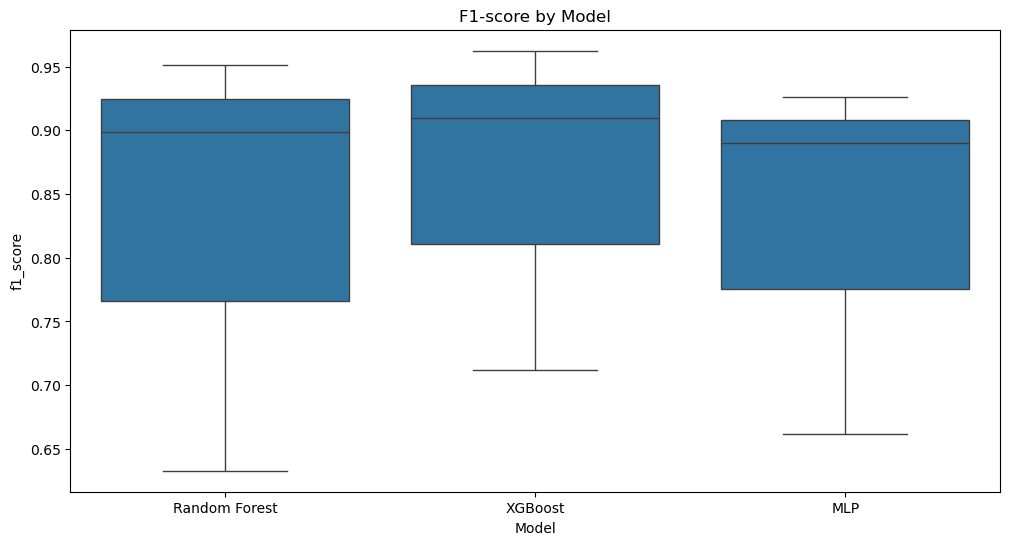

In [37]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="Model", y="f1_score", data=results_df)
plt.title("F1-score by Model")
plt.show()

# Retraining
- According to `experiment_results.csv`: SMOTE method achieved the highest performance
- Retrain the model using the following combinations and their corresponding best hyperparameters:
  - SMOTE + XGBoost
  - SMOTE + Random Forest
  - SMOTE + MLP

In [38]:
exclude_cols = {"Resampling", "Model", "model", "accuracy", "precision", "recall", "f1_score"}

In [39]:
X_final_smote, y_final_smote = smote_pipeline(X_final_dummy, y)

Using SMOTE
Before sampling: {0: 659512, 1: 90488}
After sampling: {0: 659512, 1: 659512}


## SMOTE + XGBoost

In [40]:
params = results_df.query('Model == "XGBoost" and Resampling == "SMOTE"').iloc[0]

params_xbg = {
    k: v for k, v in params.items()
    if k not in exclude_cols and pd.notna(v)
}
params_xbg["n_estimators"] = int(params_xbg["n_estimators"])
params_xbg["max_depth"] = int(params_xbg["max_depth"])

xgb = XGBClassifier(**params_xbg, random_state=42)
xgb.fit(X_final_smote, y_final_smote)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8500844882071409
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


## SMOTE + Random Forest

In [41]:
params = results_df.query('Model == "Random Forest" and Resampling == "SMOTE"').iloc[0]

params_rf = {
    k: int(v) for k, v in params.items()
    if k not in exclude_cols and pd.notna(v)
}

rf = RandomForestClassifier(**params_rf, random_state=42)
rf.fit(X_final_smote, y_final_smote)

,n_estimators,168
,criterion,'gini'
,max_depth,13
,min_samples_split,10
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


## SMOTE + MLP

In [42]:
params = results_df.query('Model == "MLP" and Resampling == "SMOTE"').iloc[0]

params_mlp = {
    k: v for k, v in params.items()
    if k not in exclude_cols and pd.notna(v)
}
params_mlp["batch_size"] = int(params_mlp["batch_size"])
# params_mlp["hidden_layer_sizes"]) = ast.literal_eval(params_mlp["hidden_layer_sizes"])

mlp = MLPClassifier(**params_mlp, max_iter=300, early_stopping=True, random_state=42)
mlp.fit(X_final_smote, y_final_smote)

,hidden_layer_sizes,"(256, ...)"
,activation,'tanh'
,solver,'adam'
,alpha,0.00018663625966315733
,batch_size,256
,learning_rate,'constant'
,learning_rate_init,0.00035401812582364105
,power_t,0.5
,max_iter,300
,shuffle,True
,random_state,42


## Save the models

In [43]:
joblib.dump(xgb, "./trained models/SMOTE+XGBoost.pkl")
joblib.dump(rf, "./trained models/SMOTE+RF.pkl")
joblib.dump(mlp, "./trained models/SMOTE+MLP.pkl")

['./trained models/SMOTE+MLP.pkl']

# Inference

In [44]:
# xbg = joblib.load("./trained models/SMOTE+XGBoost.pkl")
# rf = joblib.load("./trained models/SMOTE+RF.pkl")
# mlp = joblib.load("./trained models/SMOTE+MLP.pkl")

In [45]:
X_test = pd.get_dummies(test_df[final_features])
test_ids = test_df["id"]

In [46]:
pred_xgb = xgb.predict_proba(X_test)[:, 1]
pred_rf = rf.predict_proba(X_test)[:, 1]
pred_mlp = mlp.predict_proba(X_test)[:, 1]

/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/Users/johnny_hsieh/anaconda3/envs/n_kaggle_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


# Export results

In [47]:
submissions = {
    "XGBoost": pred_xgb,
    "Random Forest": pred_rf,
    "MLP": pred_mlp
}

for name, preds in submissions.items():
    sub_df = pd.DataFrame({
        "id": test_ids,
        "y": preds
    })
    sub_df.to_csv(f"./submissions/1106_submission_{name}.csv", index=False)